# Udacity Machine Learning Nanodegree Capstone Project

## Nonlinear Parameter Estimation of an Industrial Chemical Digester using Deep Learning Time Series Models

<i> Terry Snow 14/9/2019 </i>

### Data Review

This notebook reviews the raw data set of process history that will be used to train and test the time series models. The raw dataset is a continuous historical recording of process values around a chemical reactor process that digests a mineral from an ore slurry using a reagent from a liquor stream and energy from direct injection of high pressure steam to get the mixture to a temperature that the kinetics of the reaction can occur within the digester. The temperature that the reaction occurs at is above atmospheric boiling and the digester operates as a pressure vessel.

30 days of process data collected at 1 minute intervals makes up the data set. In keeping with real world issues, the raw data includes an outage period.

The data channels are:

| Input Variables        | Output Variables            |
|------------------------|-----------------------------|
| LiqF - Liquor Flow     | DigT - Digester Temperature |
| OreF - Ore Slurry Flow | DigP - Digester Pressure    |
| StmF - Steam Flow      |                             |


### Objectives of Data Review
- Establish the descriptive statistics of the overall data set
- Develop an algorithm that will break the data set into consecutive batches that are suitable for time series modeling for the purposes of parameter estimation
- Produce the batches using that algorithm



In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

%matplotlib inline

In [181]:
datafile = 'data/rawdatav2.csv'
rawdf = pd.read_csv(datafile)

In [182]:
rawdf.describe()

,DigT,DigP,LiqF,StmF,OreF
count,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000
mean,243.691867,3352.877331,1171.114823,158.129684,168.745655
std,15.689750,1134.539503,414.115950,53.637296,64.122599
min,198.816437,-0.819533,-1.868454,0.000000,0.000000
25%,245.046005,3639.142090,1216.354126,165.749634,167.447174
50%,250.009247,3762.839844,1299.185669,177.038910,190.061905
75%,251.273148,3853.213379,1398.179321,183.111282,206.799469
max,253.835159,4237.448242,1500.966553,267.500977,276.000336


In [175]:
tot_minutes = len(rawdf['DigT'])
print('Total duration of data set in days, hours = {0} Days {1:.2f} Hours'.format(tot_minutes // (60*24),tot_minutes % (60*24) / 60.))

Total duration of data set in days, hours = 30 Days 0.02 Hours


In [221]:
def lineplot_df(df):
    f,ax = plt.subplots(5, 1, figsize=(15,15));
    sns.lineplot(data=df['LiqF'], ax=ax[0]).set_title('Input: Liquor Flow'), ax[0].set_xticklabels([])
    sns.lineplot(data=df['StmF'], ax=ax[1]).set_title('Input: Steam Flow'), ax[1].set_xticklabels([])
    sns.lineplot(data=df['OreF'], ax=ax[2]).set_title('Input: Ore Flow'), ax[2].set_xticklabels([])
    sns.lineplot(data=df['DigT'], ax=ax[3]).set_title('Output: Digester Temperature'), ax[3].set_xticklabels([])
    sns.lineplot(data=df['DigP'], ax=ax[4]).set_title('Output: Digester Pressure'), ax[4].set_xlabel('Time in Minutes');
    xticks = [i for i in range(0,len(df),1440)]
    for a in ax.reshape(-1):
        a.xaxis.grid(which='major')
        a.set_xticks(xticks)
        plt.sca(a)
        plt.xticks(rotation='vertical')

In [209]:
def lineplot_df2(dfs):
    f,ax = plt.subplots(5, 2, figsize=(15,15));
    max_y = -1000000. * np.ones(5)
    min_y = 1000000. * np.ones(5)
    for i in [0, 1]:
        sns.lineplot(data=dfs[i]['LiqF'], ax=ax[0,i]).set_title('Input: Liquor Flow'), ax[0,i].set_xticklabels([])
        sns.lineplot(data=dfs[i]['StmF'], ax=ax[1,i]).set_title('Input: Steam Flow'), ax[1,i].set_xticklabels([])
        sns.lineplot(data=dfs[i]['OreF'], ax=ax[2,i]).set_title('Input: Ore Flow'), ax[2,i].set_xticklabels([])
        sns.lineplot(data=dfs[i]['DigT'], ax=ax[3,i]).set_title('Output: Digester Temperature'), ax[3,i].set_xticklabels([])
        sns.lineplot(data=dfs[i]['DigP'], ax=ax[4,i]).set_title('Output: Digester Pressure'),ax[4,i].set_xlabel('Time in Minutes');
        for j in range(5):
            max_y[j] = max(max_y[j],ax[j,i].get_ylim()[1])
            min_y[j] = min(min_y[j],ax[j,i].get_ylim()[0])
    for i in [0, 1]:
        for j in range(5):
            ax[j, i].set_ylim((min_y[j], max_y[j]))
    

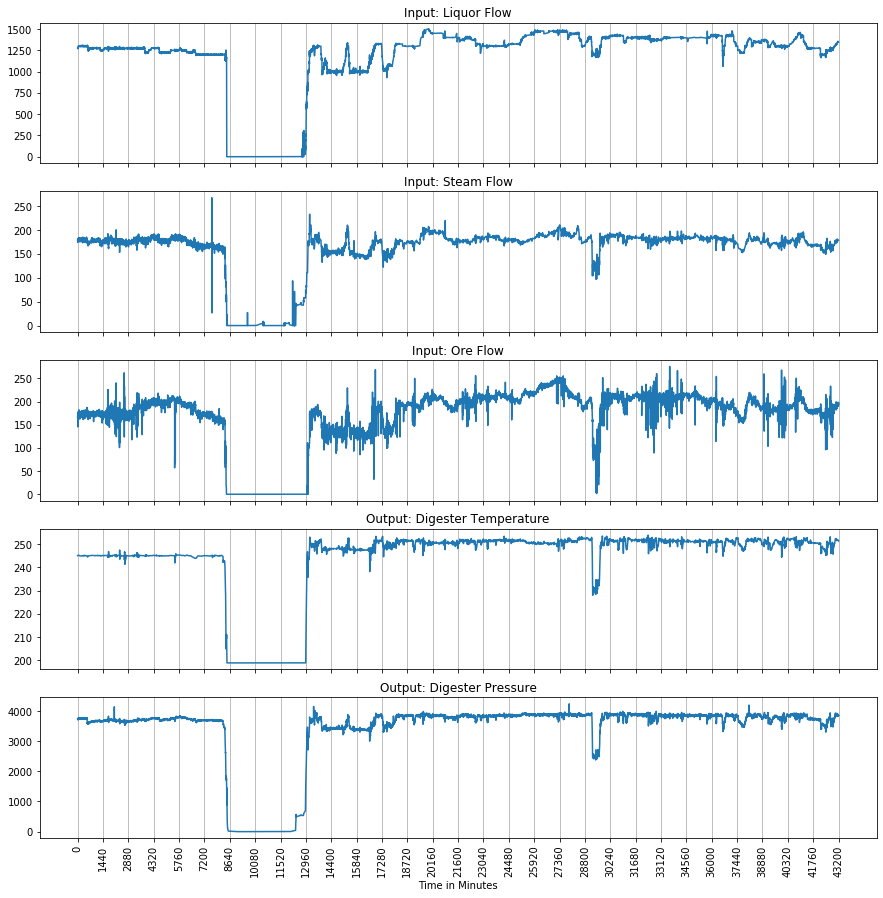

In [222]:
lineplot_df(rawdf)

The full dataset trends illustrate some potential issues for parameter estimation of sensitivity relationships:
- There are different operating ranges for the inputs at different periods 
- The high frequency noise level is different at different periods
- The dynamic range of the inputs is different at different periods

## Batching the data into 24 hour batches
Contiguous slices of process data from the dataset are required to train the DL Network. The reason for choosing a contiguous slice is that the characteristics of the Digester Vessels during that period are not expected to change much. The Digester Vessel characteristics change over time as scale builds up inside the vessel, and eventually the Digester Vessel is taken out of service and cleaned.

The contiguous time slice for training batch has to be long enough that there are sufficient examples of different operating levels and short enough that the Digester Characteristics would not have expected to have measurably changed. 24 hours is likely to be a reasonable period for a training batch.

The initial approach will be create a function that can extract a time slice of a certain amount from the data set. I will use that function to extract a number of training batches and compare and contrast those batches.

In [47]:
def make_batch(df, idx_start, n_size):
    df_len = len(df)
    if idx_start + n_size > df_len:
        return pd.DataFrame([]), False
    return df[idx_start:idx_start + n_size].copy(), True

In [225]:
BATCH_LENGTH = 24*60
df_batch4000, batchDF_isOK = make_batch(rawdf,15840,BATCH_LENGTH)
df_batch19000, batchDF_isOK = make_batch(rawdf,24480,BATCH_LENGTH)

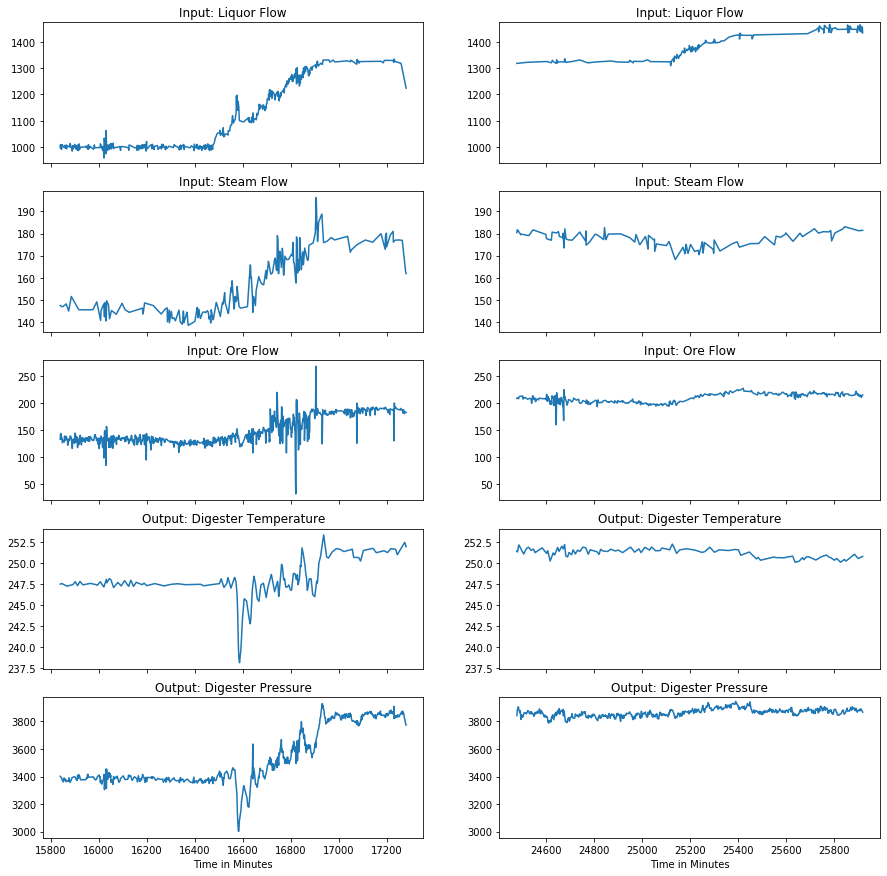

In [226]:
lineplot_df2([df_batch4000, df_batch19000])

In [227]:
df_batch4000.describe()

,DigT,DigP,LiqF,StmF,OreF
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,248.331713,3522.770965,1134.032221,157.756800,151.161358
std,2.137818,204.575778,140.320495,14.552178,25.731155
min,238.163193,3001.196533,958.437500,138.535782,32.388752
25%,247.385994,3377.751160,1001.009811,145.487614,131.234608
50%,247.522995,3402.316162,1093.650085,148.877296,138.467033
75%,250.541809,3774.458984,1308.787171,174.807377,181.089935
max,253.315903,3930.000244,1334.111938,196.297317,269.072388


In [228]:
df_batch19000.describe()

,DigT,DigP,LiqF,StmF,OreF
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,251.172500,3865.822340,1376.229510,177.589239,210.778195
std,0.486879,26.959368,52.092980,3.011162,8.198731
min,250.064590,3788.063965,1308.809937,168.300873,160.570511
25%,250.693752,3846.728394,1324.068542,175.347187,203.646061
50%,251.349503,3866.608154,1370.076843,178.072960,212.084656
75%,251.552238,3883.445800,1427.683289,179.877174,217.592739
max,252.222961,3946.268066,1465.468750,183.094132,228.305618


### Discussion on differences between the batches
The trends have been scaled so that the vertical axis is the same for both data batches to assist in the visual comparison. <br>
Visually batchdf_4000 (right hand side trends) correlates better than batchdf_19000. Batchdf_4000 has a larger dynamic range for the inputs than that of Batchdf_19000. Using Liquor Flow as an example batchdf_4000 has a dynamic range (maximum to minimum) in the order of 300 flow units, where batchdf_19000 has a dynamic range in the order of 150 flow units (1/3 rd the range). batchdf_19000 also has much more significant variation in the output measurements that does not appear to be correlated to the measured process outputs. The digester could have been subjected to unmeasured process disturbance during the time period of batchdf_19000. <br>

The comparison of these two data sets would suggest that it would be more likely that we can fit a model to batchdf_4000 than fit a model to batchdf_19000. A numerical measure of correlation that accounted for process dynamics could provide a threshold metric that could be used to automatically reject a batch if there was insufficient correlation to attempt time series modeling.

## Preprocessing Options: Improving correlation with Digital Filtering Preprocessing
Correlation between the inputs and outputs of the Digester can be improved through Digital Filtering, which can attenuate the high frequency content of the signals. It can be argued that the high frequency content is associated with effects that are not of interest to the gaol of the project, such as transient localized process behavior, instrumentation noise, unmeasured high frequency process disturbances.

Low pass filtering also has the effect of reducing the dynamic range of the signals, which will also attenuate nonlinear sensitivity characteristic that we are seeking to extract from the data.

The Deep Learning Time-Series model is expected to also perform some form of filtering. We could train the model from unfiltered data, or from filtered data. Understanding the difference between these two approaches is of significant value, and both approaches will be undertaken in this project.

### Low Pass Filter Design

A 5th Order Butterworth low pass filter was developed using the scipy signal package, with a cutoff frequency that corresponds to a filter time constant of 200 minutes.

The processing that is done of the signals is not real-time, it is from historical data, and should a production application be developed from this project it could also work on historical data. The significance of this aspect is that the digital filtering does not have to be causal. The filtering was applied to the signals using <i>filtfilt</i> which has a zero phase impact on the data.

For the purposes of visual correlation, a filtered input (<i>Steam Flow</i>) is plotted on the same graph as the filtered output (<i>Digester Pressure</i>). By placing the output trace on the secondary axis of the graph, the plot performs range normalization. 

A manual time shift of 30 sampling intervals was applied to the filtered output signal, which provided a good alignment between the input and outputs.

The digital filtering was done for the two different process data batches and is present in the following cells.

### Discussion on effect of filtering on the correlations
Both batches showed clear improvement in the correlation based on visual comparison. <i>batchdf_4000</i> shows a very close correlation, and <i>batchdf_19000</i> now also shows a much more obvious correlation.

This analysis suggests that it should be easier to train a time series model by using low-pass digitally filtered data.
The analysis also indicates that the number of delays that are required between the inputs and the pressure output is in the order of 30 samples.

In [230]:
N = 5
Wn = 0.01 #sampling rate of 1 minute, then nyquist rate is 2 minutes, low pass cutoff time constant of 200 minutes
b, a = scipy.signal.butter(N, Wn, 'low')
steamfilt_signal1 = scipy.signal.filtfilt(b, a, df_batch4000['StmF'])
tempfilt_signal1 = scipy.signal.filtfilt(b, a, df_batch4000['DigT'])
pressurefilt_signal1 = scipy.signal.filtfilt(b, a, df_batch4000['DigP'])
steamfilt_signal2 = scipy.signal.filtfilt(b, a, df_batch19000['StmF'])
pressurefilt_signal2 = scipy.signal.filtfilt(b, a, df_batch19000['DigP'])
tempfilt_signal2 = scipy.signal.filtfilt(b, a, df_batch19000['DigT'])

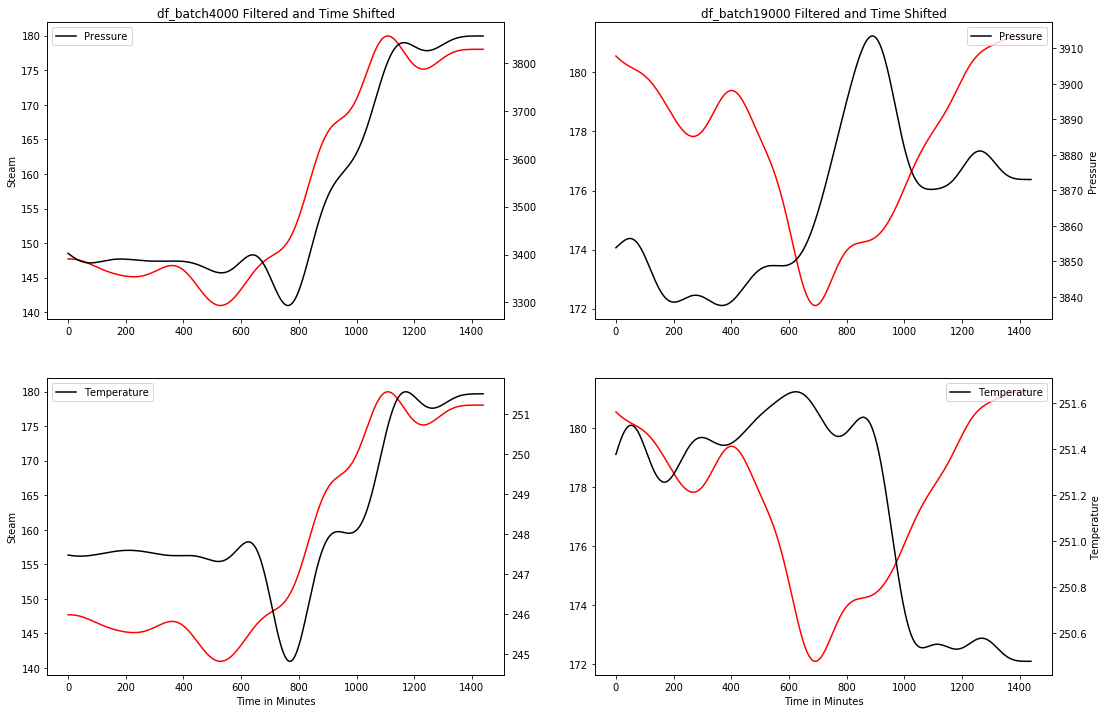

In [232]:
fig,ax = plt.subplots(2,2, figsize=(18,12))
PRESS_TIME_SHIFT = 0
TEMP_TIME_SHIFT = 0
sns.lineplot(data = steamfilt_signal1, color='r',ax = ax[0,0]).set_title('df_batch4000 Filtered and Time Shifted')
ax01 = ax[0,0].twinx()
ax[0,0].set_ylabel('Steam')
sns.lineplot(data = pressurefilt_signal1[PRESS_TIME_SHIFT:],color='k', ax = ax01, label='Pressure')
labs = [l.get_label() for l in lns]

sns.lineplot(data = steamfilt_signal2, color='r',ax = ax[0,1]).set_title('df_batch19000 Filtered and Time Shifted')
ax02 = ax[0,1].twinx()
ax02.set_ylabel('Pressure')
sns.lineplot(data = pressurefilt_signal2[PRESS_TIME_SHIFT:],color='k', ax = ax02, label='Pressure');

sns.lineplot(data = steamfilt_signal1, color='r',ax = ax[1,0])
ax11 = ax[1,0].twinx()
ax[1,0].set_xlabel('Time in Minutes')
ax[1,0].set_ylabel('Steam')
sns.lineplot(data = tempfilt_signal1[TEMP_TIME_SHIFT:],color='k', ax = ax11, label='Temperature')
labs = [l.get_label() for l in lns]

sns.lineplot(data = steamfilt_signal2, color='r',ax = ax[1,1])
ax12 = ax[1,1].twinx()
ax[1,1].set_xlabel('Time in Minutes')
ax12.set_ylabel('Temperature')
sns.lineplot(data = tempfilt_signal2[TEMP_TIME_SHIFT:],color='k', ax = ax12, label='Temperature');

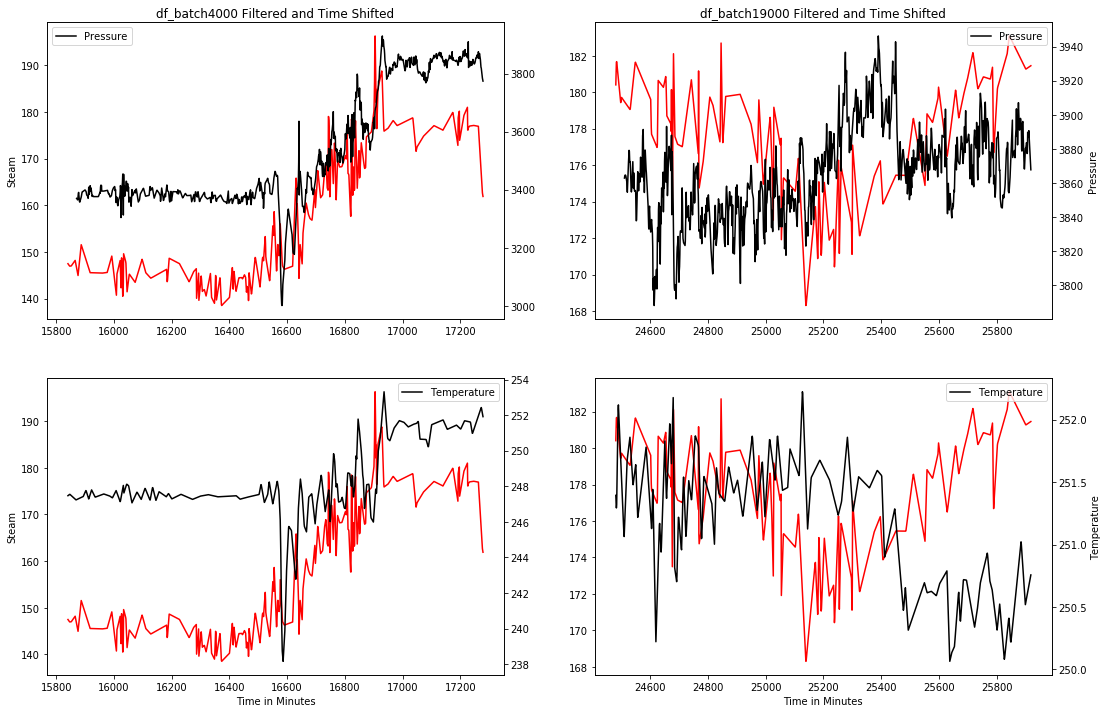

In [233]:
steamfilt_signal1 = df_batch4000['StmF']
tempfilt_signal1 = df_batch4000['DigT']
pressurefilt_signal1 = df_batch4000['DigP']
steamfilt_signal2 = df_batch19000['StmF']
pressurefilt_signal2 = df_batch19000['DigP']
tempfilt_signal2 = df_batch19000['DigT']

fig,ax = plt.subplots(2,2, figsize=(18,12))
PRESS_TIME_SHIFT = 30
TEMP_TIME_SHIFT = 0
sns.lineplot(data = steamfilt_signal1, color='r',ax = ax[0,0]).set_title('df_batch4000 Filtered and Time Shifted')
ax01 = ax[0,0].twinx()
ax[0,0].set_ylabel('Steam')
sns.lineplot(data = pressurefilt_signal1[PRESS_TIME_SHIFT:],color='k', ax = ax01, label='Pressure')
labs = [l.get_label() for l in lns]

sns.lineplot(data = steamfilt_signal2, color='r',ax = ax[0,1]).set_title('df_batch19000 Filtered and Time Shifted')
ax02 = ax[0,1].twinx()
ax02.set_ylabel('Pressure')
sns.lineplot(data = pressurefilt_signal2[PRESS_TIME_SHIFT:],color='k', ax = ax02, label='Pressure');

sns.lineplot(data = steamfilt_signal1, color='r',ax = ax[1,0])
ax11 = ax[1,0].twinx()
ax[1,0].set_xlabel('Time in Minutes')
ax[1,0].set_ylabel('Steam')
sns.lineplot(data = tempfilt_signal1[TEMP_TIME_SHIFT:],color='k', ax = ax11, label='Temperature')
labs = [l.get_label() for l in lns]

sns.lineplot(data = steamfilt_signal2, color='r',ax = ax[1,1])
ax12 = ax[1,1].twinx()
ax[1,1].set_xlabel('Time in Minutes')
ax12.set_ylabel('Temperature')
sns.lineplot(data = tempfilt_signal2[TEMP_TIME_SHIFT:],color='k', ax = ax12, label='Temperature');

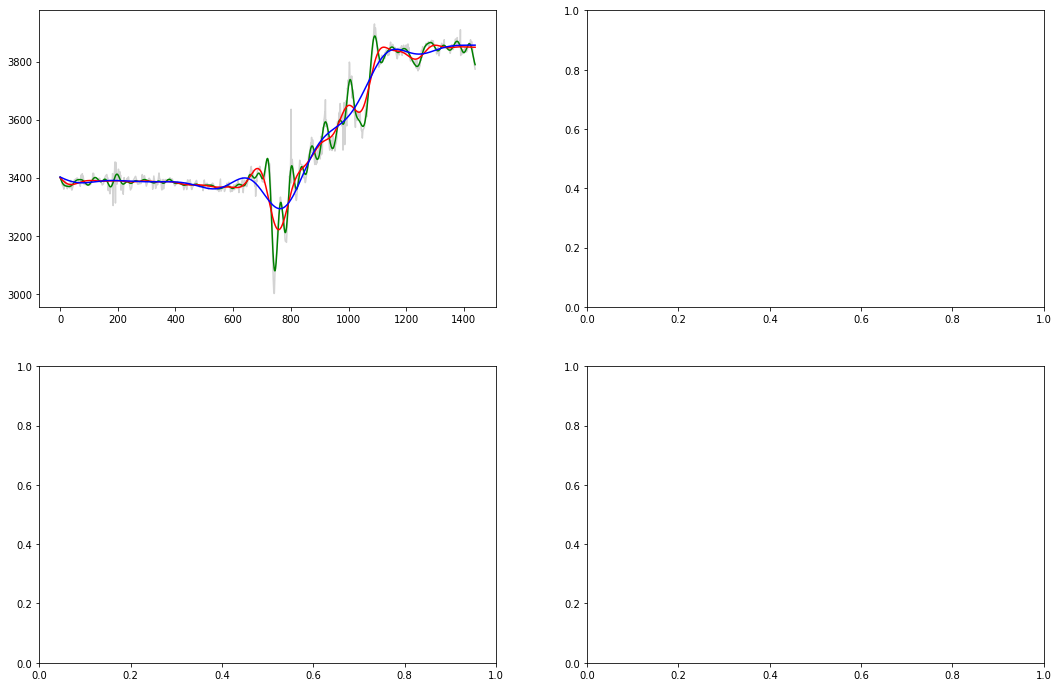

In [246]:
Wn = [1.0, .06, .02,.01]
c = ['lightgrey', 'g', 'r', 'b']
psig = []
psig.append(df_batch4000['DigP'].copy().reset_index(drop=True))
for i in range(len(Wn)-1):
    b, a = scipy.signal.butter(N, Wn[i+1], 'low')
    psig.append(scipy.signal.filtfilt(b, a, df_batch4000['DigP']))
fig,ax = plt.subplots(2,2, figsize=(18,12))
for i, data in enumerate(psig):
    sns.lineplot(data = data,ax = ax[0,0], color=c[i])


In [166]:
pressurefilt_signal1.head()

,index,pressure
0,4000,3790.350098
1,4001,3793.512207
2,4002,3799.171143
3,4003,3804.362793
4,4004,3805.493408
